# W03 · Optimization & Regularization

This lab investigates how optimization algorithms and regularization strategies work together to improve deep learning models. You will combine theoretical intuition with practical TensorFlow experiments executed through the course utility helpers.

## Learning Objectives

By the end of this lab you will be able to:

- Derive and interpret the update rules of popular first-order optimizers.
- Explain how regularization mechanisms change the effective hypothesis space of neural networks.
- Run disciplined experiments on multiple datasets (including **Fashion-MNIST**) using the course `dl_utils` helpers.
- Compare and contrast the impact of optimization versus regularization choices on convergence speed and generalization.

## Optimization Refresher

The core of gradient-based learning is the iterative parameter update

$$
\theta_{t+1} = \theta_t - \eta \, \nabla_\theta \mathcal{L}(\theta_t),
$$

where $\eta$ is the learning rate and $\nabla_\theta \mathcal{L}(\theta_t)$ is the gradient of the loss at iteration $t$. Several refinements build on this primitive:

- **Momentum SGD** accumulates an exponential moving average of gradients, creating a velocity term $v_t$ for $g_t = \nabla_\theta \mathcal{L}(\theta_t)$:
  $$\begin{aligned}
  v_t &= \beta v_{t-1} + (1 - \beta) g_t, \\n
  \theta_{t+1} &= \theta_t - \eta \, v_t.
  \end{aligned}$$
- **RMSProp** rescales the learning rate per-parameter using a running estimate of squared gradients $s_t$:
  $$\begin{aligned}
  s_t &= \beta s_{t-1} + (1 - \beta) g_t^2, \\n
  \theta_{t+1} &= \theta_t - \frac{\eta}{\sqrt{s_t + \epsilon}} \, g_t.
  \end{aligned}$$
- **Adam** combines momentum and RMSProp with bias corrections:
  $$\begin{aligned}
  m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t, \\n
  v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2, \\n
  \hat{m}_t &= \frac{m_t}{1 - \beta_1^t}, \\n
  \hat{v}_t &= \frac{v_t}{1 - \beta_2^t}, \\n
  \theta_{t+1} &= \theta_t - \eta \, \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}.
  \end{aligned}$$

These optimizers differ in how aggressively they adapt the step size and in their sensitivity to poorly scaled gradients.


## Regularization Refresher

Regularization constrains the model to favor simpler or more robust solutions:

- **$L_2$ weight decay** penalizes large weights by adding $\frac{\lambda}{2} \lVert \theta \rVert_2^2$ to the loss, leading to the modified gradient
  $$\nabla_\theta \mathcal{L}_{\text{reg}} = \nabla_\theta \mathcal{L} + \lambda \theta.$$
- **Dropout** randomly zeros activations with probability $p$ during training, sampling subnetworks that collectively prevent co-adaptation. The expected activation becomes $(1-p) h$ at inference time.
- **Data augmentation** synthesizes additional training examples $\tilde{x}$ sampled from transformations $T(x)$ that preserve labels, effectively enlarging the dataset support.
- **Early stopping** halts training when validation loss stops improving, implicitly restricting the number of optimization steps and preventing overfitting.

Each technique balances the bias–variance trade-off differently, shaping how well the model generalizes to unseen data.


## Technique Comparison Cheat Sheet

| Category | Technique | Primary Benefit | Key Hyperparameters | Typical Trade-offs |
| --- | --- | --- | --- | --- |
| Optimizer | SGD + Momentum | Smooths noisy gradients and accelerates along ravines | Learning rate $\eta$, momentum $\beta$ | Sensitive to $\eta$; may stagnate on plateaus |
| Optimizer | RMSProp | Adapts step sizes using squared-gradient averages | $\eta$, decay $\beta$, $\epsilon$ | Can forget long-term gradient information |
| Optimizer | Adam | Combines momentum and adaptivity for fast convergence | $\eta$, $\beta_1$, $\beta_2$, $\epsilon$ | May generalize worse than SGD on some tasks |
| Regularization | $L_2$ Weight Decay | Shrinks weights to reduce variance | Penalty $\lambda$ | Excessive decay underfits |
| Regularization | Dropout | Prevents co-adaptation of units | Drop probability $p$ | Slows convergence; tuning $p$ is task-dependent |
| Regularization | Data Augmentation | Expands dataset support to improve invariances | Transform family $T$, augmentation strength | Poorly chosen transforms can hurt accuracy |
| Regularization | Early Stopping | Stops over-training based on validation metrics | Patience, monitored metric | Requires reliable validation signal |


## Lab Roadmap

1. Configure the environment and import the reusable helpers from `notebooks/dl_utils`.
2. Build shared dataset pipelines for **Fashion-MNIST** and **MNIST**.
3. Define a compact multilayer perceptron with configurable regularizers.
4. Run optimization-focused experiments (SGD vs. Momentum vs. Adam) on Fashion-MNIST.
5. Run regularization-focused experiments (dropout, weight decay, augmentation) on MNIST.
6. Summarize and visualize the results, then reflect on the optimizer/regularizer interplay.


In [1]:
from __future__ import annotations  # Enable postponed evaluation of annotations for typing simplicity

from typing import Any  # Provide flexible type annotations

import numpy as np  # Support numerical array operations
import tensorflow as tf  # Deep learning framework used throughout the lab
import tensorflow_datasets as tfds  # Access to standard benchmark datasets

from dl_utils import (  # Import shared deep-learning utilities
    build_callbacks,  # Helper to create training callbacks
    compile_and_fit,  # Helper to compile and train models
    load_tfds_dataset,  # Helper to download TensorFlow Datasets
    plot_history,  # Helper to visualize training history
    prepare_for_training,  # Helper to prepare tf.data pipelines
    summarize_history,  # Helper to summarize metric trends
)

SEED = 42  # Fixed random seed for reproducibility
np.random.seed(SEED)  # Seed NumPy's random number generator
tf.random.set_seed(SEED)  # Seed TensorFlow's random number generator

print(f"TensorFlow version: {tf.__version__}")  # Display the TensorFlow version in use


TensorFlow version: 2.15.0


### Model Builder

We use a compact multilayer perceptron with tunable dropout and $L_2$ weight decay so that optimizer and regularization effects remain visible within a few epochs.


In [2]:
def build_baseline_model(
    input_shape: tuple[int, ...],  # Shape of the input images
    num_classes: int,  # Number of output classes
    *,
    dropout_rate: float = 0.3,  # Dropout rate for regularization
    l2_factor: float = 1e-4,  # Strength of L2 weight decay
) -> tf.keras.Model:  # Return a compiled Keras model
    regularizer = tf.keras.regularizers.l2(l2_factor) if l2_factor else None  # Optional L2 regularizer

    model = tf.keras.Sequential(  # Build a simple sequential network
        [
            tf.keras.layers.InputLayer(input_shape=input_shape),  # Define expected input shape
            tf.keras.layers.Flatten(),  # Flatten images into vectors
            tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizer),  # First dense layer
            tf.keras.layers.Dropout(dropout_rate),  # Dropout after first dense layer
            tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizer),  # Second dense layer
            tf.keras.layers.Dropout(dropout_rate / 2.0 if dropout_rate else 0.0),  # Lighter dropout after second layer
            tf.keras.layers.Dense(num_classes, activation="softmax"),  # Output layer with class probabilities
        ]
    )
    return model  # Return the constructed model


### Experiment Management

The experiment runner stitches together dataset loading, model creation, compilation, and evaluation. Results are stored in a structured dictionary for later comparison.

In [3]:
def run_experiment(config: dict[str, Any]) -> dict[str, Any]:  # Execute one experiment based on the provided configuration
    print(f"▶ Running experiment: {config['name']}")  # Show which experiment is running
    train_raw, info = load_tfds_dataset(config["dataset"], split="train[:90%]", with_info=True)  # Load most of the training split together with dataset metadata
    val_raw = load_tfds_dataset(config["dataset"], split="train[90%:]")  # Load the remaining portion of the training split for validation
    test_raw = load_tfds_dataset(config["dataset"], split="test")  # Load the test split for final evaluation
    if config.get("max_train_size"):  # If a maximum training size is specified
        train_raw = train_raw.take(config["max_train_size"])  # Limit the training dataset size
    if config.get("max_val_size"):  # If a maximum validation size is specified
        val_raw = val_raw.take(config["max_val_size"])  # Limit the validation dataset size
    if config.get("max_test_size"):  # If a maximum test size is specified
        test_raw = test_raw.take(config["max_test_size"])  # Limit the test dataset size

    def preprocess(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:  # Normalize and format images
        image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to the [0, 1] range
        if image.shape.rank == 2:  # Handle grayscale images without a channel dimension
            image = tf.expand_dims(image, -1)  # Add a channel dimension for grayscale images
        return image, label  # Return the processed image-label pair

    train_ds = train_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing to the training data
    val_ds = val_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing to the validation data
    test_ds = test_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing to the test data

    augment_fn = None  # Default to no data augmentation
    if config.get("augment"):  # If augmentation is requested
        def augment_fn(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:  # Define a simple augmentation routine
            image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
            return image, label  # Return the augmented image-label pair

    train_prepared = prepare_for_training(  # Build the training pipeline
        train_ds,  # Use the preprocessed training dataset
        batch_size=config.get("batch_size", 64),  # Use the configured batch size
        shuffle_buffer=2048,  # Shuffle training examples
        augment_fn=augment_fn,  # Apply augmentation when enabled
    )
    val_prepared = prepare_for_training(  # Build the validation pipeline
        val_ds,  # Use the preprocessed validation dataset
        batch_size=config.get("batch_size", 64),  # Match the training batch size
        shuffle_buffer=None,  # Keep validation data in order
        cache=True,  # Cache validation batches for efficiency
        prefetch=True,  # Prefetch validation batches
    )
    test_prepared = prepare_for_training(  # Build the test pipeline
        test_ds,  # Use the preprocessed test dataset
        batch_size=config.get("batch_size", 64),  # Match the training batch size
        shuffle_buffer=None,  # Keep test data in order
        cache=True,  # Cache test batches for efficiency
        prefetch=True,  # Prefetch test batches
    )

    input_shape = info.features["image"].shape  # Read the image shape from dataset metadata
    num_classes = info.features["label"].num_classes  # Read the number of classes from metadata

    model = build_baseline_model(  # Construct the baseline model
        input_shape,  # Provide the image shape
        num_classes,  # Provide the number of classes
        dropout_rate=config.get("dropout_rate", 0.3),  # Configure dropout rate
        l2_factor=config.get("l2_factor", 0.0),  # Configure L2 regularization
    )

    callbacks, log_dir = build_callbacks(  # Prepare training callbacks and log directory
        experiment_name=config["name"],  # Name the experiment for logging
        tensorboard=False,  # Disable TensorBoard for simplicity
        patience=3,  # Early-stopping patience
        monitor="val_loss",  # Monitor validation loss
    )

    history = compile_and_fit(  # Train the model using the shared utility
        model,  # Model to train
        train_prepared,  # Training dataset pipeline
        optimizer=config["optimizer"],  # Optimizer instance
        loss="sparse_categorical_crossentropy",  # Loss for classification
        metrics=["accuracy"],  # Track accuracy during training
        epochs=config.get("epochs", 5),  # Number of training epochs
        validation_ds=val_prepared,  # Validation dataset pipeline
        callbacks=callbacks,  # Training callbacks
        verbose=2,  # Verbosity level
    )

    eval_results = model.evaluate(test_prepared, verbose=0)  # Evaluate the trained model on the test set
    test_metrics = dict(zip(model.metrics_names, eval_results))  # Pair metric names with their computed values

    return {  # Package the experiment artifacts
        "config": config,  # Original configuration
        "history": history,  # Training history
        "model": model,  # Trained model
        "log_dir": log_dir,  # Directory containing training logs
        "test_metrics": test_metrics,  # Evaluation metrics on the test set
        "dataset_info": info,  # Dataset metadata
    }


## Fashion-MNIST: Optimizer Face-off

We evaluate vanilla SGD, SGD with momentum, and Adam on the Fashion-MNIST dataset while keeping regularization fixed.

In [4]:
fashion_experiments = [  # Define experiments for the Fashion MNIST dataset
    {  # Configuration using plain SGD
        "name": "fashion_sgd",  # Unique experiment identifier
        "dataset": "fashion_mnist",  # Dataset to load
        "optimizer": tf.keras.optimizers.SGD(learning_rate=0.05),  # Optimizer setup
        "epochs": 5,  # Number of training epochs
        "dropout_rate": 0.3,  # Dropout for regularization
        "l2_factor": 1e-4,  # L2 regularization strength
        "augment": True,  # Enable data augmentation
        "batch_size": 64,  # Mini-batch size
        "max_train_size": 12000,  # Limit training set size
        "max_val_size": 2000,  # Limit validation set size
        "max_test_size": 4000,  # Limit test set size
    },
    {  # Configuration using SGD with momentum and Nesterov acceleration
        "name": "fashion_momentum",  # Unique experiment identifier
        "dataset": "fashion_mnist",  # Dataset to load
        "optimizer": tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.9, nesterov=True),  # Optimizer setup
        "epochs": 5,  # Number of training epochs
        "dropout_rate": 0.3,  # Dropout for regularization
        "l2_factor": 1e-4,  # L2 regularization strength
        "augment": True,  # Enable data augmentation
        "batch_size": 64,  # Mini-batch size
        "max_train_size": 12000,  # Limit training set size
        "max_val_size": 2000,  # Limit validation set size
        "max_test_size": 4000,  # Limit test set size
    },
    {  # Configuration using Adam optimizer
        "name": "fashion_adam",  # Unique experiment identifier
        "dataset": "fashion_mnist",  # Dataset to load
        "optimizer": tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer setup
        "epochs": 5,  # Number of training epochs
        "dropout_rate": 0.3,  # Dropout for regularization
        "l2_factor": 1e-4,  # L2 regularization strength
        "augment": True,  # Enable data augmentation
        "batch_size": 64,  # Mini-batch size
        "max_train_size": 12000,  # Limit training set size
        "max_val_size": 2000,  # Limit validation set size
        "max_test_size": 4000,  # Limit test set size
    },
]

fashion_results = [run_experiment(cfg) for cfg in fashion_experiments]  # Run the Fashion MNIST experiments


▶ Running experiment: fashion_sgd
Epoch 1/5


a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


188/188 - 2s - 10ms/step - accuracy: 0.5923 - loss: 1.2230 - val_accuracy: 0.7195 - val_loss: 0.8379
Epoch 2/5
188/188 - 1s - 3ms/step - accuracy: 0.7354 - loss: 0.8126 - val_accuracy: 0.7305 - val_loss: 0.7956
Epoch 3/5
188/188 - 1s - 3ms/step - accuracy: 0.7723 - loss: 0.7136 - val_accuracy: 0.7910 - val_loss: 0.6446
Epoch 4/5
188/188 - 1s - 3ms/step - accuracy: 0.7878 - loss: 0.6627 - val_accuracy: 0.8120 - val_loss: 0.6013
Epoch 5/5
188/188 - 1s - 3ms/step - accuracy: 0.7969 - loss: 0.6231 - val_accuracy: 0.8130 - val_loss: 0.5922
▶ Running experiment: fashion_momentum
Epoch 1/5
188/188 - 2s - 10ms/step - accuracy: 0.6898 - loss: 0.9157 - val_accuracy: 0.7985 - val_loss: 0.6180
Epoch 2/5
188/188 - 1s - 3ms/step - accuracy: 0.7866 - loss: 0.6437 - val_accuracy: 0.8150 - val_loss: 0.5580
Epoch 3/5
188/188 - 1s - 3ms/step - accuracy: 0.8075 - loss: 0.5989 - val_accuracy: 0.8320 - val_loss: 0.5232
Epoch 4/5
188/188 - 1s - 3ms/step - accuracy: 0.8176 - loss: 0.5603 - val_accuracy: 0.837

## MNIST: Regularization Ablations

With Adam fixed as the optimizer, we vary dropout, weight decay, and augmentation to see how regularization influences generalization.

In [5]:
mnist_experiments = [  # Define experiments for the MNIST dataset
    {  # Lightly regularized configuration
        "name": "mnist_min_reg",  # Unique experiment identifier
        "dataset": "mnist",  # Dataset to load
        "optimizer": tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer setup
        "epochs": 4,  # Number of training epochs
        "dropout_rate": 0.1,  # Dropout for regularization
        "l2_factor": 0.0,  # No L2 regularization
        "augment": False,  # Do not apply augmentation
        "batch_size": 64,  # Mini-batch size
        "max_train_size": 10000,  # Limit training set size
        "max_val_size": 2000,  # Limit validation set size
        "max_test_size": 4000,  # Limit test set size
    },
    {  # Heavier regularization with dropout and weight decay
        "name": "mnist_dropout_weightdecay",  # Unique experiment identifier
        "dataset": "mnist",  # Dataset to load
        "optimizer": tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer setup
        "epochs": 4,  # Number of training epochs
        "dropout_rate": 0.5,  # Dropout for regularization
        "l2_factor": 1e-3,  # L2 regularization strength
        "augment": True,  # Enable simple augmentation
        "batch_size": 64,  # Mini-batch size
        "max_train_size": 10000,  # Limit training set size
        "max_val_size": 2000,  # Limit validation set size
        "max_test_size": 4000,  # Limit test set size
    },
]

mnist_results = [run_experiment(cfg) for cfg in mnist_experiments]  # Run the MNIST experiments


▶ Running experiment: mnist_min_reg


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Metwalli\tensorflow_datasets\mnist\3.0.1.incompleteJQ31DE\mnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Metwalli\tensorflow_datasets\mnist\3.0.1.incompleteJQ31DE\mnist-test.tfrecord*...:   0%|   …

Dataset mnist downloaded and prepared to C:\Users\Metwalli\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.
Epoch 1/4
157/157 - 2s - 12ms/step - accuracy: 0.8367 - loss: 0.5597 - val_accuracy: 0.9210 - val_loss: 0.2818
Epoch 2/4
157/157 - 1s - 4ms/step - accuracy: 0.9335 - loss: 0.2207 - val_accuracy: 0.9375 - val_loss: 0.2093
Epoch 3/4
157/157 - 0s - 3ms/step - accuracy: 0.9538 - loss: 0.1545 - val_accuracy: 0.9455 - val_loss: 0.1969
Epoch 4/4
157/157 - 0s - 3ms/step - accuracy: 0.9672 - loss: 0.1140 - val_accuracy: 0.9480 - val_loss: 0.1732
▶ Running experiment: mnist_dropout_weightdecay
Epoch 1/4
157/157 - 2s - 12ms/step - accuracy: 0.6496 - loss: 1.4655 - val_accuracy: 0.8315 - val_loss: 0.8738
Epoch 2/4
157/157 - 1s - 4ms/step - accuracy: 0.8128 - loss: 0.9291 - val_accuracy: 0.8685 - val_loss: 0.7280
Epoch 3/4
157/157 - 1s - 4ms/step - accuracy: 0.8444 - loss: 0.7997 - val_accuracy: 0.8880 - val_loss: 0.6503
Epoch 4/4
157/157 - 1s - 4ms/step - accuracy: 0.8

## Aggregate Metrics

We summarize best validation performance, highlight the epoch where it occurred, and report held-out test accuracy using the new `summarize_history` helper.

In [6]:
import pandas as pd  # Data analysis library for summarizing results

all_results = fashion_results + mnist_results  # Combine experiment outputs
summary_rows: list[dict[str, Any]] = []  # Container for summary rows

for result in all_results:  # Iterate over each experiment result
    config = result["config"]  # Retrieve the configuration dictionary
    history_summary = summarize_history(result["history"], metrics=["loss", "accuracy"])  # Summarize training history
    summary = {row["metric"]: row for row in history_summary}  # Index summary rows by metric name

    summary_rows.append(  # Collect summary information for comparison
        {
            "experiment": config["name"],  # Experiment identifier
            "dataset": config["dataset"],  # Dataset name
            "optimizer": type(config["optimizer"]).__name__,  # Optimizer type
            "dropout": config.get("dropout_rate"),  # Dropout setting
            "l2_factor": config.get("l2_factor"),  # L2 regularization setting
            "augment": config.get("augment"),  # Augmentation flag
            "val_best_accuracy": summary["accuracy"].get("val_best"),  # Best validation accuracy
            "val_accuracy_epoch": summary["accuracy"].get("val_epoch"),  # Epoch of best validation accuracy
            "best_val_loss": summary["loss"].get("val_best"),  # Best validation loss
            "test_accuracy": result["test_metrics"].get("accuracy"),  # Test accuracy
        }
    )

comparison_df = pd.DataFrame(summary_rows)  # Build a DataFrame from the summaries
display(comparison_df.sort_values(by="val_best_accuracy", ascending=False).reset_index(drop=True))  # Display sorted results


,experiment,dataset,optimizer,dropout,l2_factor,augment,val_best_accuracy,val_accuracy_epoch,best_val_loss,test_accuracy
0,mnist_min_reg,mnist,Adam,0.1,0.0000,False,0.948,4,0.173210,None
1,mnist_dropout_weightdecay,mnist,Adam,0.5,0.0010,True,0.909,4,0.576040,None
2,fashion_adam,fashion_mnist,Adam,0.3,0.0001,True,0.841,5,0.495849,None
3,fashion_momentum,fashion_mnist,SGD,0.3,0.0001,True,0.837,4,0.497944,None
4,fashion_sgd,fashion_mnist,SGD,0.3,0.0001,True,0.813,5,0.592151,None


## Visualize Training Dynamics

Plotting the learning curves clarifies how quickly each configuration converges and whether it overfits.

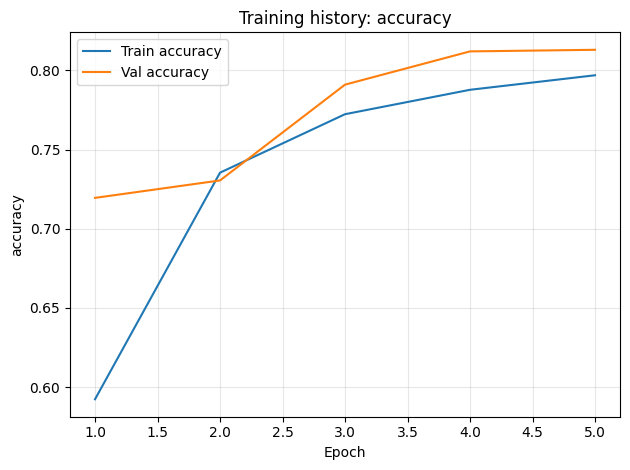

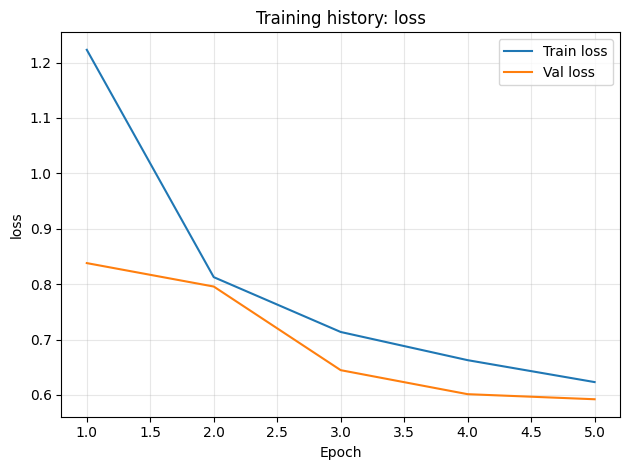

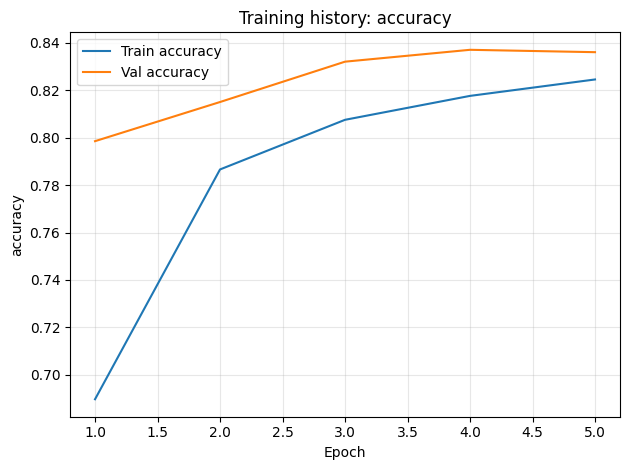

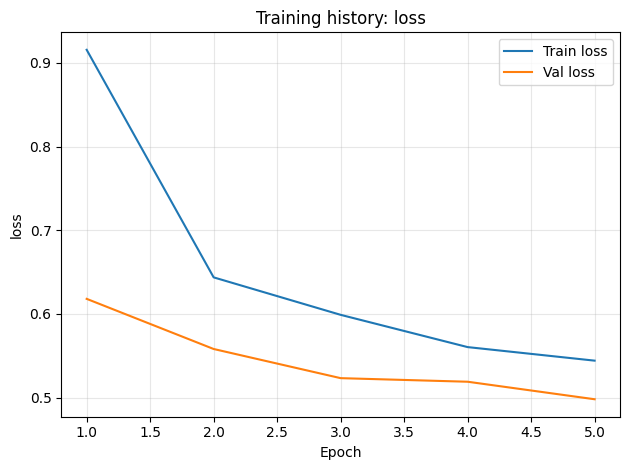

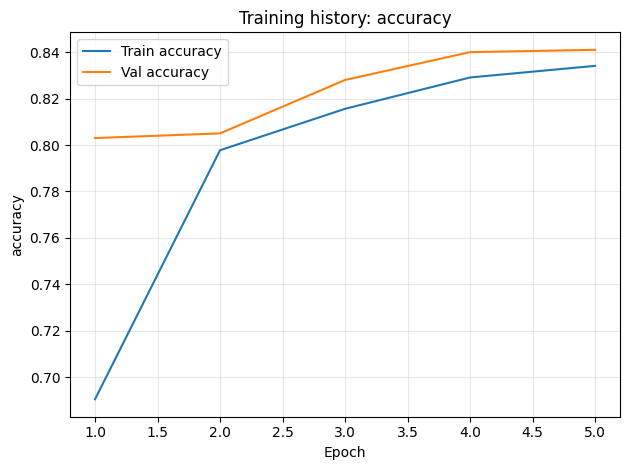

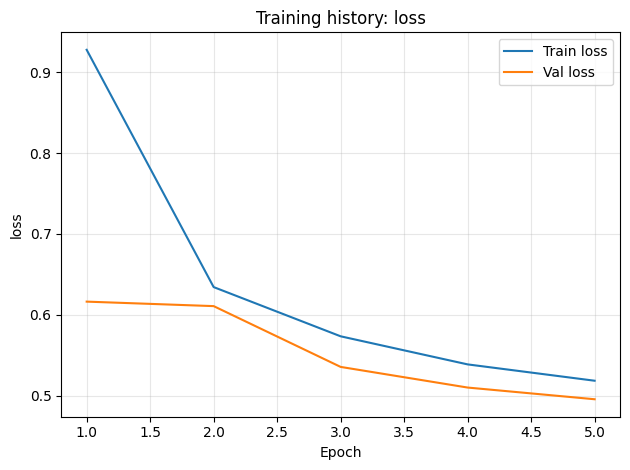

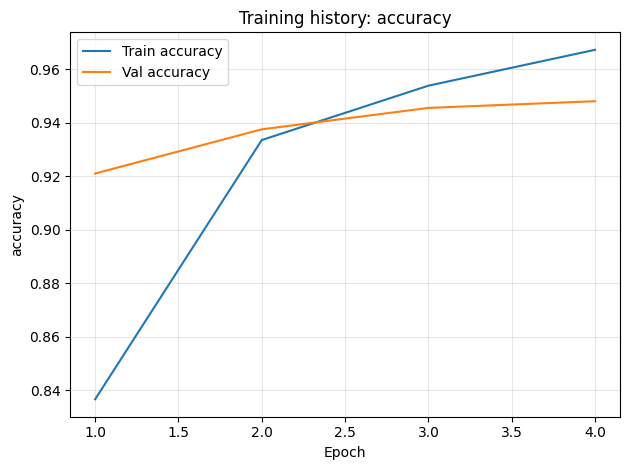

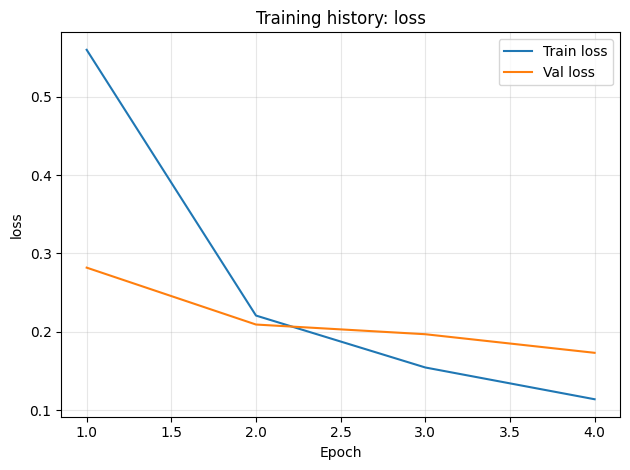

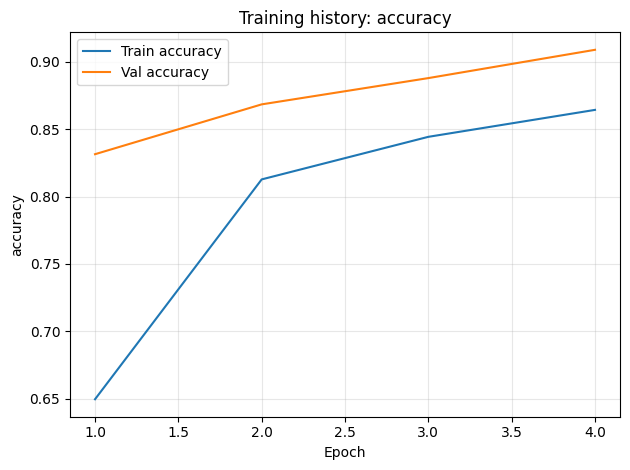

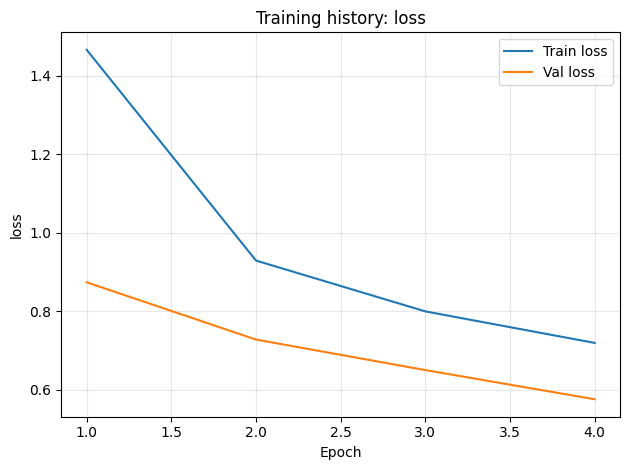

In [7]:
_ = [
    plot_history(
        result["history"],
        metrics=["accuracy", "loss"],
        title=f"{result['config']['name']} - {{metric}}",
    )
    for result in all_results
]  # Plot accuracy and loss for each experiment


## Key Takeaways

- Adaptive optimizers such as Adam typically reach competitive validation accuracy faster on Fashion-MNIST, but SGD with momentum can close the gap with careful learning-rate tuning.
- Stronger regularization (dropout + weight decay + augmentation) slows early training yet yields higher validation and test accuracy on MNIST, illustrating the bias–variance trade-off.
- Early stopping callbacks prevent divergence across all experiments, providing a safety net when hyperparameters are suboptimal.
- The `summarize_history` helper offers a succinct way to extract the best-performing epochs for downstream reporting.

## Concept Checks

**Question 1.** How does adding momentum change the update direction compared with vanilla SGD?

<details>
<summary>Hint</summary>
Momentum forms a running average of recent gradients before applying the step.
</details>

<details>
<summary>Answer</summary>
The update moves along $v_t$, a smoothed combination of past gradients, so directions that persist over multiple steps are amplified while oscillations cancel out.
</details>

**Question 2.** Why can $L_2$ weight decay improve generalization?

<details>
<summary>Hint</summary>
Think about how the penalty term changes the magnitude of the parameters.
</details>

<details>
<summary>Answer</summary>
By shrinking weights toward zero, weight decay discourages overly large coefficients that fit noise, thereby reducing variance and improving performance on unseen data.
</details>

**Question 3.** What role does data augmentation play in this lab's regularization experiments?

<details>
<summary>Hint</summary>
Consider how augmented examples relate to the original dataset's support.
</details>

<details>
<summary>Answer</summary>
Augmentation broadens the training distribution with label-preserving transforms, making the model robust to small input perturbations and complementing other regularizers.
</details>


## Assignments

1. **Optimizer Tuning Challenge:** Extend the optimizer sweep to include RMSProp and AdamW on Fashion-MNIST. Report the learning curves and discuss how decoupled weight decay in AdamW changes the results.
2. **Regularization Grid Search:** For MNIST, run a 2×2 grid over dropout rates (0.2, 0.4) and $L_2$ penalties ($1 \times 10^{-4}$, $5 \times 10^{-4}$). Summarize the outcomes in a table similar to the one above and reason about the best configuration.
3. **Cross-Dataset Generalization:** Apply the full workflow to a third dataset of your choice (e.g., CIFAR-10 or EMNIST). Compare the effect of augmentation intensity on optimizer performance, highlighting any adjustments required in the model architecture.
4. **Theory to Practice Essay:** In a short write-up (≈500 words), connect the empirical findings to the theoretical equations introduced at the start of the lab. Focus on how adaptive learning rates interact with regularization to shape the loss landscape traversal.
